# Evaluation for eff Model

In [ ]:
import os
print(os.getcwd())  # 显示当前工作目录


c:\Users\40920\anaconda3\envs\trainenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧩 使用默认采样策略（无 source 字段）
📊 数据集构建完成：共 9900 条样本，类别数：33
✅ 修改 `conv_stem` 输入通道: 1 → 32
✅ 分类层输出维度: 33


C:\Users\40920\AppData\Local\Temp\ipykernel_35940\1636854792.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CONFIG["model_path"], map_location=

📊 分类报告已保存: E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments/exp11_alltype0408_mel_drop0.2_addgauss/eval_results_best_model\classification_report.txt


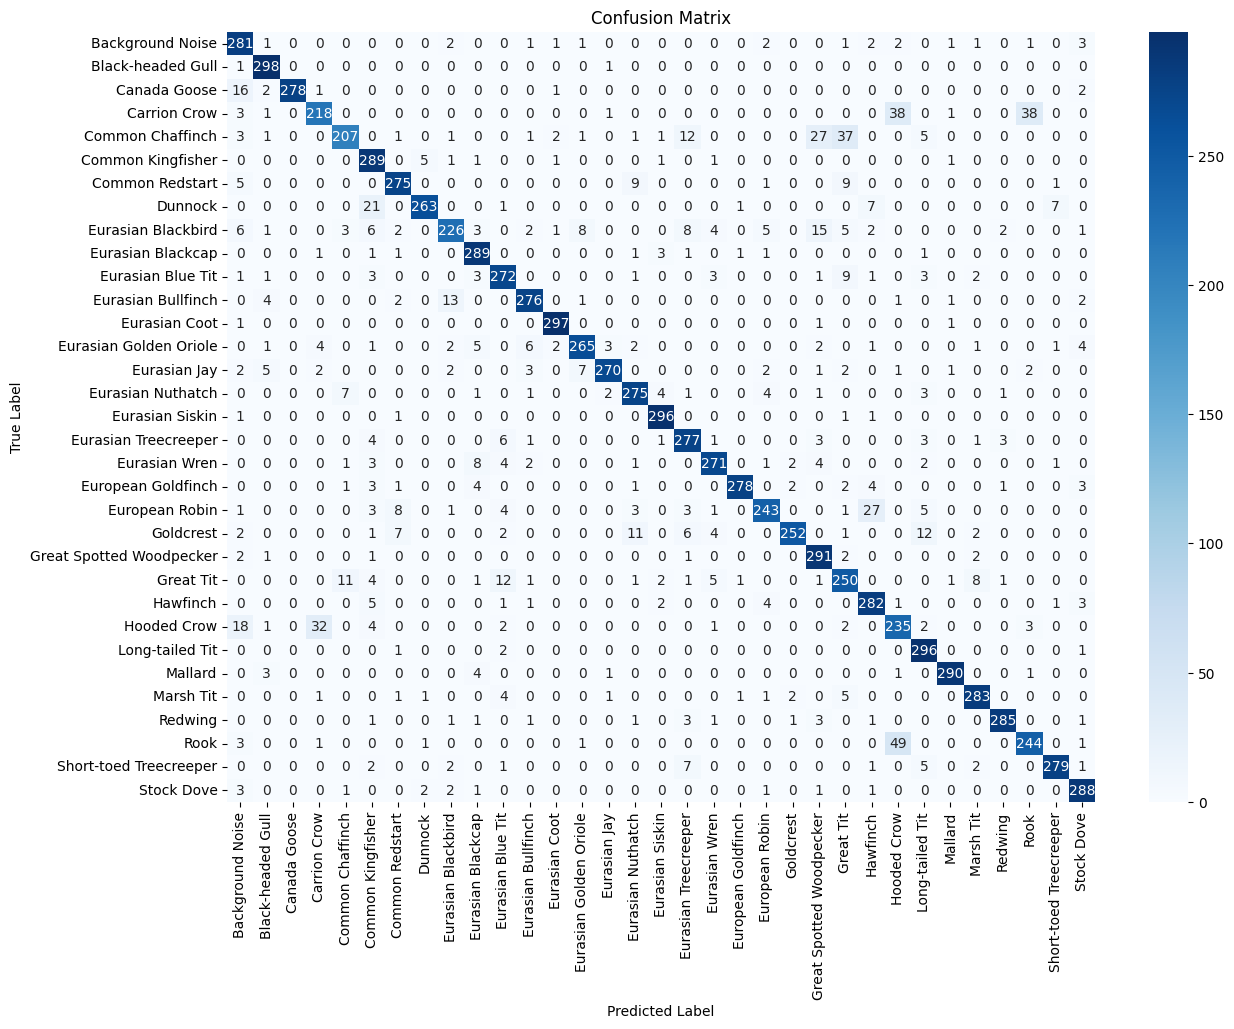

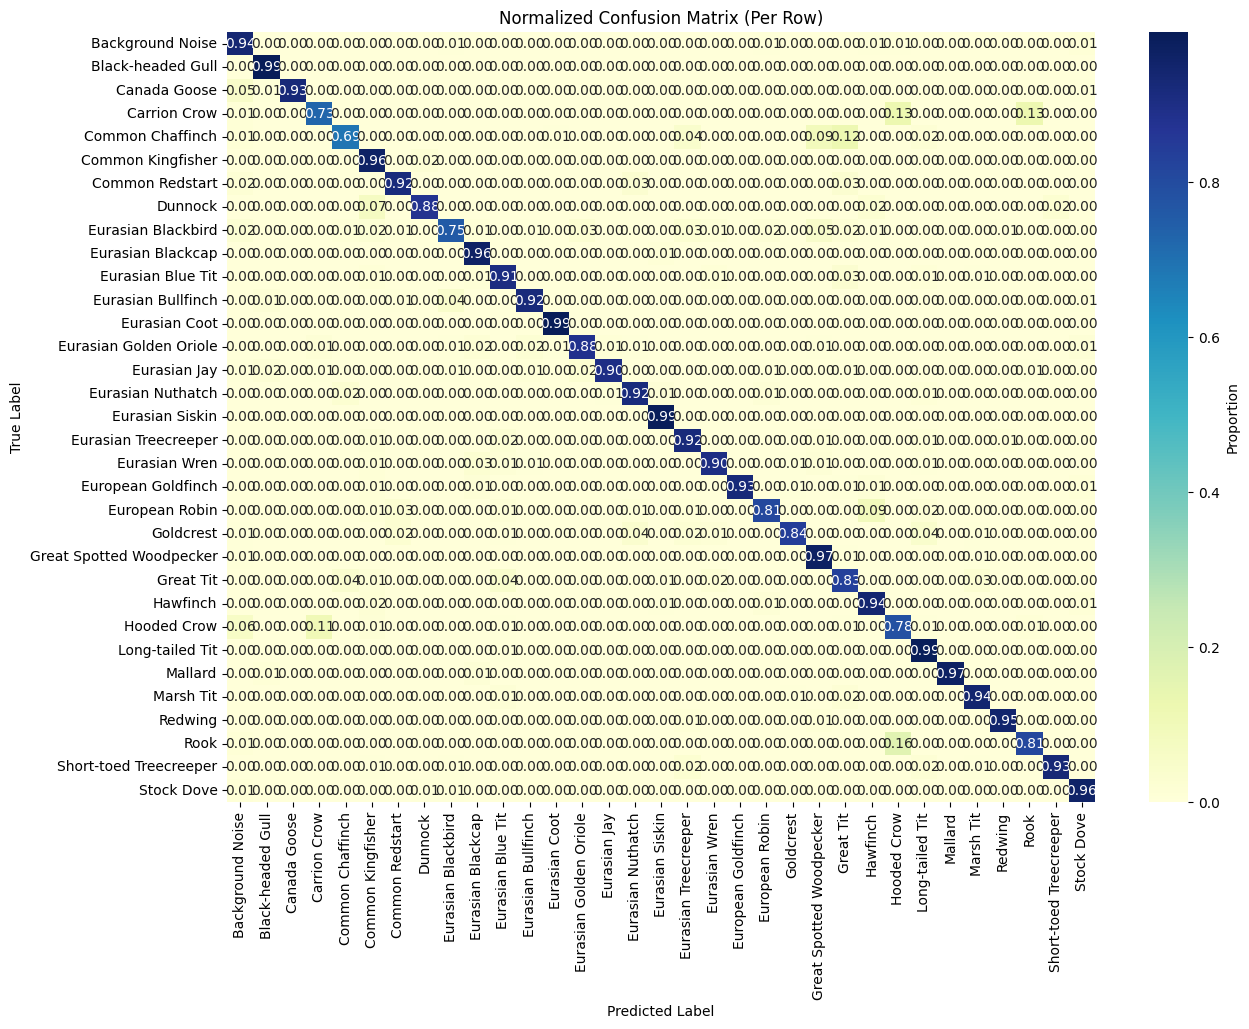

C:\Users\40920\AppData\Local\Temp\ipykernel_35940\1636854792.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', CONFIG["num_classes"])


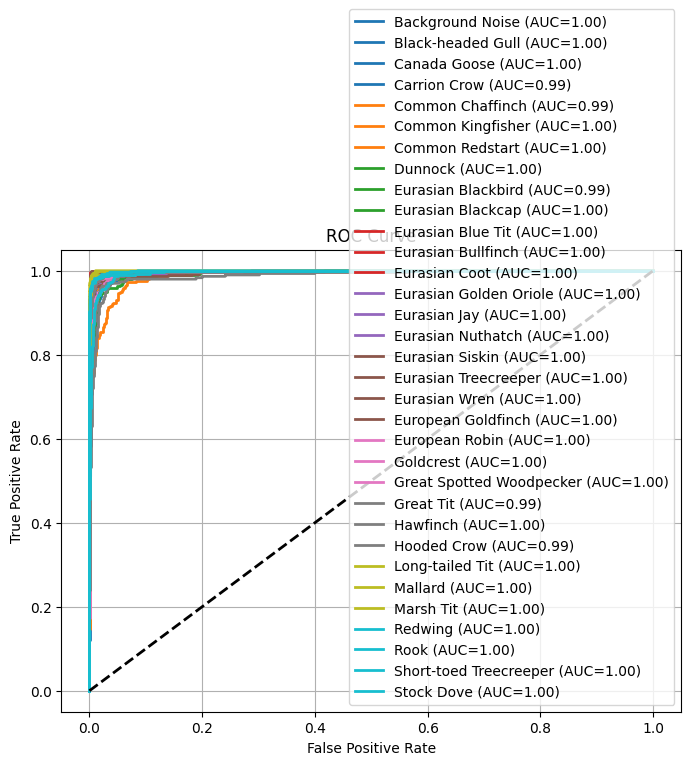

📊 推理结果已保存
📊 类别混淆统计已保存


In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from data.dataset import get_dataloader
from model.model import EfficientNetModel
from bird_name_mapping import bird_name_mapping
from data.utils_bird_mapping import get_class_labels, build_index_to_label  # ✅ 新增工具函数

# ✅ 配置
exp_name = 'exp11_alltype0408_mel_drop0.2_addgauss'
valid_list_name = '0408/valid_list_high_quality.csv'
model_name = 'best_model'

CONFIG = {
    "valid_csv": f"E:/AMR/DA/Projekt/data/data_list/{valid_list_name}",
    "model_path": f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments/{exp_name}/models/{model_name}.pth",
    "num_classes": len(set(bird_name_mapping.values())),  # ✅ 确保是 label 数
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model_type": "EfficientNet",
    "model_version": "b0",
    "input_channel": 1,
    "output_dir": f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments/{exp_name}/eval_results_{model_name}",
    "dropout_rate": 0.2
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)

# ✅ 统一 class_labels 名称
class_labels = get_class_labels(bird_name_mapping, merge_names=True)
index_to_bird = build_index_to_label(bird_name_mapping, merge_names=True)

# ✅ 加载数据
test_loader = get_dataloader(CONFIG["valid_csv"], bird_name_mapping, batch_size=CONFIG["batch_size"],
                             augment=False, use_weighted_sampler=False, model_type=CONFIG["model_type"],
                             input_channel=CONFIG["input_channel"], num_workers=4)

# ✅ 加载模型
model = EfficientNetModel(CONFIG["num_classes"], model_type=CONFIG["model_type"], version=CONFIG["model_version"],
                          pretrained=False, feature_extract=False, input_channel=CONFIG["input_channel"], dropout_rate=CONFIG["dropout_rate"])
checkpoint = torch.load(CONFIG["model_path"], map_location=CONFIG["device"])
model.load_state_dict(checkpoint["model_state_dict"])
model.to(CONFIG["device"])
model.eval()

# ✅ 推理函数
def evaluate(model, test_loader, device):
    all_preds, all_probs, all_labels, all_paths = [], [], [], []
    with torch.no_grad():
        for inputs, labels, paths in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_paths.extend(paths)
    return np.array(all_labels), np.array(all_preds), np.array(all_probs), np.array(all_paths)

# ✅ 推理评估
true_labels, pred_labels, prob_scores, sample_paths = evaluate(model, test_loader, CONFIG["device"])

accuracy = accuracy_score(true_labels, pred_labels)
conf_matrix = confusion_matrix(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, target_names=class_labels, digits=4)

# ✅ 分类报告
report_path = os.path.join(CONFIG["output_dir"], "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print(f"📊 分类报告已保存: {report_path}")

# ✅ 混淆矩阵图
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(CONFIG["output_dir"], "confusion_matrix.png"))
plt.show()

# ✅ 归一化混淆图
conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=class_labels, yticklabels=class_labels, cbar_kws={"label": "Proportion"})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Per Row)")
plt.savefig(os.path.join(CONFIG["output_dir"], "confusion_matrix_normalized.png"))
plt.show()

# ✅ ROC 曲线
true_labels_bin = label_binarize(true_labels, classes=np.arange(CONFIG["num_classes"]))
colors = plt.cm.get_cmap('tab10', CONFIG["num_classes"])
plt.figure(figsize=(8, 6))
for i in range(CONFIG["num_classes"]):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], prob_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(i), lw=2, label=f"{class_labels[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(CONFIG["output_dir"], "roc_curve.png"))
plt.show()

# ✅ 推理结果 CSV
inference_results = pd.DataFrame({
    "Path": sample_paths,
    "True Label": [class_labels[i] for i in true_labels],
    "Predicted Label": [class_labels[i] for i in pred_labels],
})
for i, name in enumerate(class_labels):
    inference_results[f"Confidence_{name}"] = prob_scores[:, i]
inference_results.to_csv(os.path.join(CONFIG["output_dir"], "evaluation_results.csv"), index=False, encoding="utf-8-sig")
print(f"📊 推理结果已保存")

# ✅ 混淆对统计
confusion_df = inference_results[inference_results["True Label"] != inference_results["Predicted Label"]]
confusion_counts = (
    confusion_df.groupby(["True Label", "Predicted Label"])
    .size()
    .reset_index(name="Count")
    .sort_values("Count", ascending=False)
)
confusion_counts.to_csv(os.path.join(CONFIG["output_dir"], "confusion_pairs.csv"), index=False, encoding="utf-8-sig")
print("📊 类别混淆统计已保存")


# Grad-CAM 可视化模型注意力

🎯 分析样本: E:/AMR/DA/Projekt/data/Audio_spec_mel_512_256\XC126838_seg25_mel.npy
✅ True: Hooded Crow, Predicted: Hooded Crow


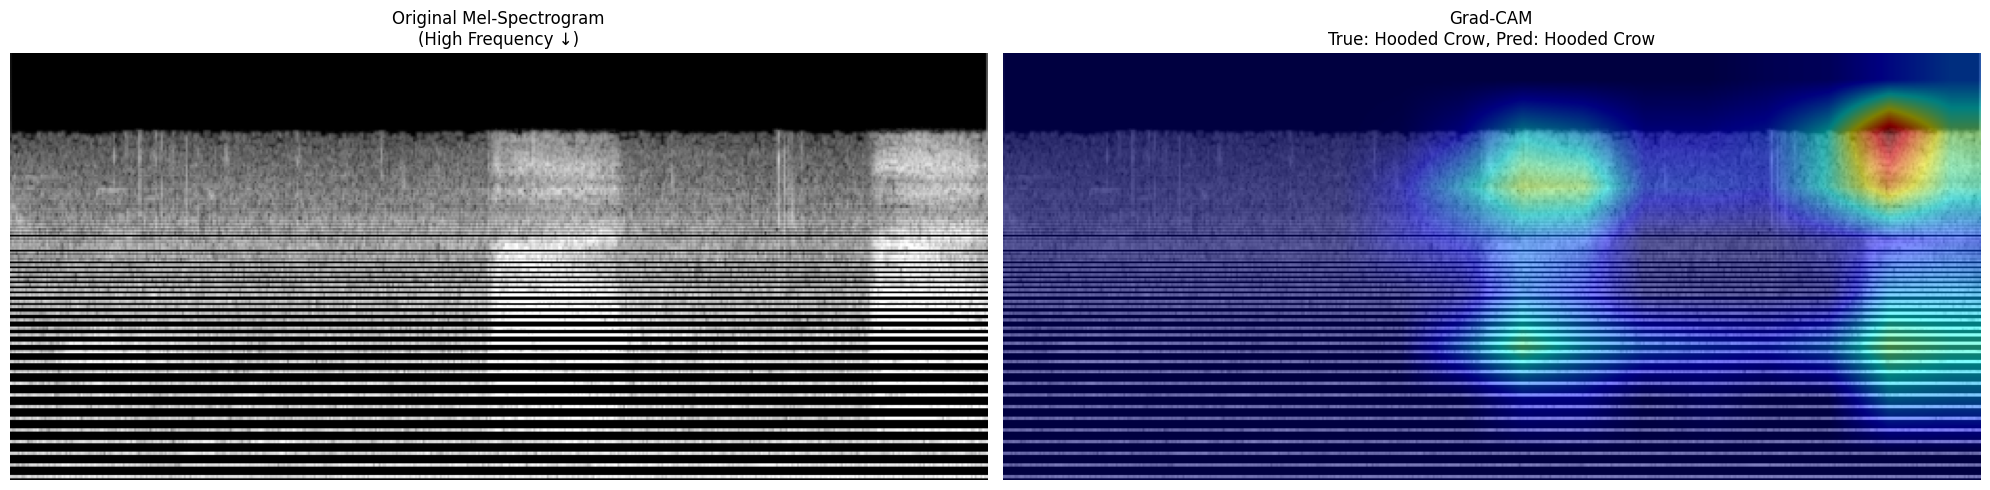

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# ✅ 获取正确分类样本
sample_info = inference_results[inference_results["True Label"] == inference_results["Predicted Label"]].iloc[6000]
sample_path = sample_info["Path"]
true_label_name = sample_info["True Label"]
pred_label_name = sample_info["Predicted Label"]
print(f"🎯 分析样本: {sample_path}")
print(f"✅ True: {true_label_name}, Predicted: {pred_label_name}")

# ✅ 加载频谱图
spec = np.load(sample_path)

# ✅ 翻转频率轴（高频在下）
spec = np.flipud(spec)

# ✅ 清洗数据，避免黑线
spec = np.nan_to_num(spec, nan=0.0)           # 替换 NaN ✅
spec = np.maximum(spec, 0)                    # 去负值 ✅
vmin, vmax = np.percentile(spec, [2, 98])     # 使用百分位范围规避异常值 ✅
spec = np.clip((spec - vmin) / (vmax - vmin + 1e-6), 0, 1) # 归一化并 clip ✅

# ✅ 构建模型输入
input_tensor = torch.tensor(spec).unsqueeze(0).unsqueeze(0).float().to(CONFIG["device"])

# ✅ 类别索引
predicted_index = list(index_to_bird.keys())[list(index_to_bird.values()).index(pred_label_name)]
targets = [ClassifierOutputTarget(predicted_index)]

# ✅ GradCAM 实例化
target_layer = model.model.blocks[-1]
cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
cam.activations_and_grads.release()

# ✅ 构建 RGB 图
spec_rgb = np.stack([spec] * 3, axis=-1)
visualization = show_cam_on_image(spec_rgb, grayscale_cam, use_rgb=True)

# ✅ 可视化
plt.figure(figsize=(20, 5))

# 原图
plt.subplot(1, 2, 1)
plt.imshow(spec, cmap="gray", origin="upper", aspect="auto") # ✅ aspect 设置更自然
plt.title("Original Mel-Spectrogram\n(High Frequency ↓)")
plt.axis("off")

# Grad-CAM
plt.subplot(1, 2, 2)
plt.imshow(visualization, aspect="auto")
plt.title(f"Grad-CAM\nTrue: {true_label_name}, Pred: {pred_label_name}")
plt.axis("off")

plt.tight_layout()
plt.show()


# 可视化badcase

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ✅ 设置参数
exp_name = 'exp11_alltype0408_mel_baseline' 
exp_root = 'E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments'
csv_path = f"{exp_root}/{exp_name}/eval_results_best_model/evaluation_results.csv"
target_class = "Great Tit"  # ✅ 真实类别（只查看该类的错误分类）
index = 0  # ✅ 选择查看的错误样本索引

# ✅ 读取推理结果 CSV
df = pd.read_csv(csv_path)

# ✅ 过滤真实类别为 `target_class` 但预测错误的样本
wrong_predictions = df[(df["True Label"] == target_class) & (df["Predicted Label"] == "Eurasian Blue Tit")].reset_index(drop=True)

# ✅ **按照 Path 排序**
wrong_predictions = wrong_predictions.sort_values(by="Path").reset_index(drop=True)

# ✅ 检查索引是否有效
if len(wrong_predictions) == 0:
    print(f"✅ 没有找到 '{target_class}' 被错误预测的样本")
elif index >= len(wrong_predictions) or index < 0:
    print(f"❌ 索引超出范围！总共有 {len(wrong_predictions)} 个错误样本，你的索引: {index}")
else:
    # ✅ 获取指定错误样本
    row = wrong_predictions.iloc[index]
    spec_path = row["Path"]  # 频谱图路径
    true_label = row["True Label"]
    pred_label = row["Predicted Label"]

    # ✅ **找到预测类别对应的置信度**
    confidence_col = f"Confidence_{pred_label}"
    if confidence_col in df.columns:
        confidence = row[confidence_col]  # 置信度分数
        confidence_text = f" | Confidence: {confidence:.4f}"
    else:
        confidence = None
        confidence_text = " | ⚠️ No Confidence Column Found"

    # ✅ 读取声谱图
    if os.path.exists(spec_path):
        spectrogram = np.load(spec_path)  # 加载 .npy 文件
    else:
        print(f"❌ 文件未找到: {spec_path}")
        spectrogram = None

    # ✅ 显示声谱图
    if spectrogram is not None:
        plt.figure(figsize=(8, 4))
        plt.imshow(spectrogram, aspect='auto', cmap='magma', origin='lower')
        plt.colorbar()
        plt.title(f"True: {true_label} | Pred: {pred_label}{confidence_text}\nPath: {spec_path}")
        plt.show()

    print(f"✅ Index: {index}/{len(wrong_predictions)-1} | True: {true_label} | Pred: {pred_label}{confidence_text}\nPath: {spec_path}")


# Infer Model

In [2]:
import os
import json
import librosa
import torch
import numpy as np
import pandas as pd
import cv2
import cupy as cp
from cupyx.scipy import signal as cupy_signal
from torch.utils.data import DataLoader, Dataset
from model.model import EfficientNetModel
import matplotlib.pyplot as plt
from bird_name_mapping import bird_name_mapping

index_to_bird = {v: k for k, v in bird_name_mapping.items()}  # 反向映射索引到鸟类名称
exp_name = 'exp11_alltype0408_mel_drop0.2_addgauss'
# ✅ **配置参数**
class config:
    FS = 48000  # 采样率
    N_FFT = 512  # FFT 点数
    WIN_SIZE = 512  # 频谱窗口大小
    WIN_LAP = 384  # 频谱窗口重叠大小
    MIN_FREQ = 150  # 最小频率
    MAX_FREQ = 15000  # 最大频率
    SEGMENT_DURATION = 3  # 每段 3 秒
    SPEC_SIZE = (512, 256)  # 频谱图大小
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    MODEL_PATH = f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments/{exp_name}/models/best_model.pth"
    OUTPUT_DIR = f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments/{exp_name}/inference_results"
    model_type = "EfficientNet"
    model_version = "b0"
    input_channel = 1
    infer_name = "ZOOM006"  # 新增 infer_name 用于动态指定推理结果的保存路径

# **确保输出目录存在**
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# ✅ **时间转换函数**
def format_time(seconds):
    """将秒转换为 mm:ss 格式"""
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes:02d}:{seconds:02d}"

# ✅ **频谱转换**
def audio_to_spectrogram(audio_data):
    audio_data = cp.array(audio_data)

    # 处理 NaN 数据
    mean_signal = cp.nanmean(audio_data) if cp.isnan(audio_data).mean() < 1 else 0
    audio_data = cp.nan_to_num(audio_data, nan=mean_signal)

    # 计算频谱
    frequencies, times, spec_data = cupy_signal.spectrogram(
        audio_data, fs=config.FS, nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, noverlap=config.WIN_LAP, window="hann"
    )

    # 过滤频率范围
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]

    # 对数变换 & 归一化
    spec_data = cp.log10(spec_data + 1e-20)
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return cv2.resize(spec_data.get(), config.SPEC_SIZE, interpolation=cv2.INTER_AREA)

def audio_to_melspec(audio_data):
    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.N_FFT - config.WIN_LAP,
        win_length=config.WIN_SIZE,
        n_mels=config.SPEC_SIZE[1],  # 高度方向 = mel 频带数
        fmin=config.MIN_FREQ,
        fmax=config.MAX_FREQ,
        window='hann',
    )
    # 512 * 256 <- 512 * 64
    # 对数缩放 & 归一化
    mel_spec = np.log10(mel_spec + 1e-9)
    mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min() + 1e-6)

    # 调整时间轴宽度
    mel_spec = cv2.resize(mel_spec, config.SPEC_SIZE, interpolation=cv2.INTER_AREA)  # shape: (H, W)

    return mel_spec


# ✅ **加载模型**
def load_model():
    model = EfficientNetModel(len(bird_name_mapping), model_type=config.model_type, version=config.model_version, pretrained=False, feature_extract=False,
                              input_channel=config.input_channel, dropout_rate=0.2)
    model.load_state_dict(torch.load(config.MODEL_PATH, map_location=config.DEVICE)["model_state_dict"])
    model.to(config.DEVICE)
    model.eval()
    return model

# ✅ **推理数据集**
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms):
        self.spectrograms = spectrograms

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        spec = self.spectrograms[idx]
        return torch.tensor(spec, dtype=torch.float32).unsqueeze(0)  # (1, 256, 256)

# ✅ **音频推理**
def infer_audio(file_path):
    # **创建推理结果目录**
    infer_output_dir = os.path.join(config.OUTPUT_DIR, config.infer_name)
    os.makedirs(infer_output_dir, exist_ok=True)

    model = load_model()

    # **读取音频**
    audio_data, _ = librosa.load(file_path, sr=config.FS)
    total_duration = len(audio_data) / config.FS
    num_segments = int(np.ceil(total_duration / config.SEGMENT_DURATION))

    # **存储结果**
    segments = []
    spectrograms = []
    for i in range(num_segments):
        start_time = i * config.SEGMENT_DURATION
        end_time = (i + 1) * config.SEGMENT_DURATION

        start_idx = start_time * config.FS
        end_idx = end_time * config.FS
        segment_audio = audio_data[start_idx:end_idx]

        # **不足 3s 填充 0**
        if len(segment_audio) < config.SEGMENT_DURATION * config.FS:
            pad_size = config.SEGMENT_DURATION * config.FS - len(segment_audio)
            segment_audio = np.pad(segment_audio, (0, pad_size), mode="constant")

        # **转换为频谱**
        spec_data = audio_to_melspec(segment_audio)
        spectrograms.append(spec_data)
        segments.append((format_time(start_time) + "-" + format_time(end_time), f"{start_time}-{end_time}", spec_data))

        # 保存频谱图为图像
        img_output_dir = os.path.join(infer_output_dir, "infer_img")
        os.makedirs(img_output_dir, exist_ok=True)
        # 保存频谱图为 .png（可视化）
        img_filename = f"segment_{i:03d}.png"
        img_path = os.path.join(img_output_dir, img_filename)
        plt.imsave(img_path, spec_data, cmap='viridis', origin='lower')

        # ✅ 同时保存 .npy（保留浮点原始数据）
        npy_filename = f"segment_{i:03d}_mel.npy"
        npy_path = os.path.join(img_output_dir, npy_filename)
        np.save(npy_path, spec_data.astype(np.float32))



    # **构造数据集**
    dataset = SpectrogramDataset([s[2] for s in segments])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # **模型推理**
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(config.DEVICE)
            outputs = model(batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)

    # **生成 CSV（未合并）**
    segment_results = [(segments[i][0], segments[i][1], index_to_bird[predictions[i]]) for i in range(len(segments))]
    segment_df = pd.DataFrame(segment_results, columns=["Time Range", "Interval", "Predicted Bird"])
    segment_df.to_csv(os.path.join(infer_output_dir, "segments.csv"), index=False, encoding="utf-8-sig")

    # ✅ **合并相邻相同类别**
    merged_results = []
    last_label = None
    start_time = None
    for time_range, interval, label in segment_results:
        if label != last_label:
            if last_label is not None:
                merged_results.append((start_time, time_range.split("-")[1], last_label))
            start_time = time_range.split("-")[0]
            last_label = label
    if last_label is not None:
        merged_results.append((start_time, time_range.split("-")[1], last_label))

    # **保存合并后的 CSV**
    merged_csv_path = os.path.join(infer_output_dir, "merged_segments.csv")
    merged_df = pd.DataFrame(merged_results, columns=["Start Time", "End Time", "Predicted Bird"])
    merged_df.to_csv(merged_csv_path, index=False, encoding="utf-8-sig")

    # ✅ **统计鸟类出现次数并保存 JSON**
    bird_counts = merged_df["Predicted Bird"].value_counts().to_dict()
    json_path = os.path.join(infer_output_dir, "bird_counts.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(bird_counts, f, ensure_ascii=False, indent=4)

    # ✅ **统计鸟类出现次数（合并前）并保存 JSON**
    bird_counts_raw = segment_df["Predicted Bird"].value_counts().to_dict()
    raw_json_path = os.path.join(infer_output_dir, "bird_counts_raw.json")
    with open(raw_json_path, "w", encoding="utf-8") as f:
        json.dump(bird_counts_raw, f, ensure_ascii=False, indent=4)

    print(f"✅ 处理完成！CSV & JSON 结果已保存在 {infer_output_dir}")


# **运行推理**
# infer_audio("E:/AMR/DA/Projekt/data/data_from_betreuer/Westpark Autumn/22.12.2015/ZOOM0023_Tr3_.wav")
# "E:/AMR/DA/Projekt/data_from_betreuer/Westpark Autumn/04.12.2015/ZOOM0025_Tr34_.wav"
# infer_audio("E:/AMR/DA/Projekt/data/Audio_files/Call - Eurasian Blue tit/XC638874.wav")
# ZOOM0007_Tr34.WAV   ZOOM0006_Tr34_0_00000_000.wav
infer_audio("E:/AMR/DA/Projekt/data/data_from_betreuer/Elisenbrunnen/12.05.2015/ZOOM0006_Tr34_0_00000_000.wav")
# infer_audio("E:/AMR/DA/Projekt/data/Audio_files/Song - Eurasian Blue tit/XC802244.wav")


c:\Users\40920\anaconda3\envs\trainenv\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
C:\Users\40920\AppData\Local\Temp\ipykernel_35940\3821144809.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_

✅ 修改 `conv_stem` 输入通道: 1 → 32
✅ 分类层输出维度: 33


c:\Users\40920\anaconda3\envs\trainenv\lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


✅ 处理完成！CSV & JSON 结果已保存在 E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments/exp11_alltype0408_mel_drop0.2_addgauss/inference_results\ZOOM006


# infer图和train图对比  看差异

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ 修改下面两个路径为你要对比的 mel 图
train_mel_path = "E:/AMR/DA/Projekt/data/Audio_spec_mel_512_256/XC638874_seg1_mel.npy"
infer_mel_path = "E:/AMR/DA/Projekt/bird_cls_cnn/projekt_eff/experiments/exp11_alltype0408_mel_baseline/inference_results/XC638874/infer_img/segment_001_mel.npy"

# ✅ 加载训练 mel
if os.path.exists(train_mel_path):
     mel_train = np.load(train_mel_path)
else:
    raise FileNotFoundError(f"❌ 找不到训练 mel 文件: {train_mel_path}")

# ✅ 加载推理 mel
if os.path.exists(infer_mel_path):
    mel_infer = np.load(infer_mel_path)
else:
    raise FileNotFoundError(f"❌ 找不到推理 mel 文件: {infer_mel_path}")

# ✅ 打印形状和范围
print(f"训练 mel 图 shape: {mel_train.shape}, range=({mel_train.min():.4f}, {mel_train.max():.4f})")
print(f"推理 mel 图 shape: {mel_infer.shape}, range=({mel_infer.min():.4f}, {mel_infer.max():.4f})")

# ✅ 计算误差（可选）
diff = np.abs(mel_train - mel_infer)
print(f"📊 差值统计：min={diff.min():.4f}, max={diff.max():.4f}, mean={diff.mean():.4f}")

# ✅ 并排显示
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(mel_train, aspect='auto', origin='lower', cmap='viridis')
plt.title("📘 Training Mel")
plt.colorbar()
plt.xlabel("Time")
plt.ylabel("Mel Frequency")

plt.subplot(1, 3, 2)
plt.imshow(mel_infer, aspect='auto', origin='lower', cmap='viridis')
plt.title("📕 Inference Mel")
plt.colorbar()
plt.xlabel("Time")
plt.ylabel("Mel Frequency")

plt.subplot(1, 3, 3)
plt.imshow(diff, aspect='auto', origin='lower', cmap='hot')
plt.title("🔍 Absolute Difference")
plt.colorbar()
plt.xlabel("Time")

plt.tight_layout()
plt.show()
